In [1]:
!pip install -q wandb
!pip install -q segmentation_models_pytorch
!pip install -q torchsummary
# !pip install -q scikit-image
from kaggle_datasets import KaggleDatasets

In [2]:
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version 1.7 --apt-packages libomp5 libopenblas-dev
# ! pip install -q pytorch-lightning==1.1.8

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

# from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
import albumentations as A

import segmentation_models_pytorch as smp
import torchsummary

import pandas as pd
import numpy as np
import random, shutil, time, os

import sklearn
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import albumentations as A

import yaml
from IPython import display as ipd
import json
from datetime import datetime

from glob import glob
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import roc_auc_score
# from skimage import color
from IPython import display as ipd

import scipy
import pdb
import gc

import tifffile as tiff 

import warnings
warnings.filterwarnings('ignore')

print('done')

done


In [4]:
# import sys
# sys.path.append('../input/unetsaug600')
# # import importlib
# # unet_module = importlib.import_module('UNet')

# import UNet as unet_module

In [5]:
model = smp.Unet(
    encoder_name='efficientnet-b7',
    decoder_use_batchnorm=True,
    activation='sigmoid',
    in_channels=3,
    classes=5,
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

In [6]:
CFG = {
    'lr':2e-3,
    'shape':(32*20, 32*20),

}

In [7]:
TRAIN = True

In [8]:
BASE_DIR = '../input/hubmap-organ-segmentation'

if TRAIN:
    DATA_DIR = os.path.join(BASE_DIR, 'train_images')
else:
    DATA_DIR = os.path.join(BASE_DIR, 'test_images')
            
df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
df['path'] = df['id'].apply(lambda fname : os.path.join(DATA_DIR, str(fname) + '.tiff'))
organ_to_class = {
    'prostate':0,
    'spleen':1,
    'lung':2,
    'kidney':3,
    'largeintestine':4
}
df['class'] = df['organ'].apply(lambda organ : organ_to_class[organ])

In [9]:
# https://www.kaggle.com/paulorzp/rle-functions-run-length-encode-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, wid, hei):
    shape = (wid, hei)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


def img_read(path):
    img = tiff.imread(path)
    return img


class Dataset2D(torch.utils.data.Dataset):
    def __init__(self, df_sub, train=True):
        ids = df_sub.id.astype(str).values
        
        self.train = train
        
        self.paths = np.array(df_sub['path'])
        self.rles = np.array(df_sub['rle'])
        self.classes = np.array(df_sub['class'])
        self.wid = np.array(df_sub['img_width'])
        self.hei = np.array(df_sub['img_height'])
        
        
    def __len__(self):
        return len(self.paths)
    
    def transform(self, img, mask):
        trans = A.Compose([
#             A.ToFloat(max_value=65535.0), # essential because albu requires 32 bits!!! ONLY THIS can force it work with 16 bits!!

            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),

            A.RandomRotate90(p=0.5),

            A.ShiftScaleRotate(
                scale_limit=0.1,  # 0
                shift_limit=0.05,  # 0.05
                rotate_limit=15,
                p=0.5,
            ),

#             A.HueSaturationValue(15,25,0, p=0.5),
#             A.OneOf(
#                 [
#                     A.GaussNoise(var_limit=(0,50.0), mean=0),
#                     A.GaussianBlur(blur_limit=(3,7)),
#                 ],
#                 p=0.5
#             ),
#             A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
#             A.RandomGamma(gamma_limit=(80, 120), p=1),
            
            A.OneOf([
                A.ElasticTransform(
                    alpha=1, 
                    sigma=25, 
#                     alpha_affine=25,
                    border_mode=cv2.BORDER_CONSTANT,
                    value=0,
                    always_apply=True,
                ),
                A.GridDistortion(always_apply=True),
                A.OpticalDistortion(distort_limit=1, shift_limit=0.2, always_apply=True),
                ], p=0.3
            ),
        ])
        return trans(image=img, mask=mask)

    
    def data_prep_aug(self, img, mask, class_num):
        shape = CFG['shape']
        
        img = cv2.resize(img, shape, interpolation=cv2.INTER_AREA).astype(np.float32)
        mask = cv2.resize(mask, shape, interpolation=cv2.INTER_AREA).astype(np.float32)
        
#         trans = self.transform(img, mask)
#         img = trans['image']
#         mask = trans['mask']
        
        # normalize
        img = (img - img.min()) / (img.max() - img.min())
        
        img = img.reshape((3, shape[0], shape[1]))

        mask_final = np.zeros((5, shape[0], shape[1]))
        mask_final[class_num, :, :] = mask
#         mask_final[5, :, :] = 1 - mask

        return torch.tensor(img), torch.tensor(mask_final)
    
    def __getitem__(self, idx):
        img = img_read(self.paths[idx])
        mask = rle_decode(self.rles[idx], self.wid[idx], self.hei[idx])

        # data preprocessing and augmentation
        img, mask = self.data_prep_aug(img, mask, self.classes[idx])
        
        return img, mask


In [10]:
class UNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
#         self.base_model = unet_module.UNet(n_channels=3, n_classes=5)
        self.base_model = smp.Unet(
            encoder_name='efficientnet-b7',
            decoder_use_batchnorm=True,
            activation='sigmoid',
            in_channels=3,
            classes=5,
        )
        self.steps_count = 0
#         self.sigmoid = nn.Sigmoid()
#         self.softmax = nn.Softmax(dim=0)

    def forward(self, x):
        x = self.base_model(x)
#         x = self.sigmoid(x)
        return x
    
    def dice_coef(self, x, y, smooth=1e-5):
#         x = x.to(torch.float32)
#         y = y.to(torch.float32)
        intersection = (x * y).sum()
        return (2. * intersection + smooth) / (x.sum() + y.sum() + smooth)

    def loss(self, y_hat, y, smooth=1):
#         y_hat = y_hat.view(-1)
#         y = y.view(-1)

#         BCE = nn.BCEWithLogitsLoss()(y_hat, y)

#         y_hat = torch.sigmoid(y_hat)
        dice_coef_ = self.dice_coef(y_hat, y, smooth)
        logcosh_dice_loss = torch.log(torch.cosh(1 - dice_coef_))

        return logcosh_dice_loss

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
#         self.steps_count += 1
#         if self.steps_count >= 50:
#             plt.subplots(1)
#             plt.imshow(y[0][0].cpu().detach().numpy())
#             plt.pause(1)
#             plt.subplots(1)
#             plt.imshow(y_hat[0][0].cpu().detach().numpy())
#             plt.pause(1)
        loss = self.loss(y_hat, y)
    
#         dice_co = self.dice_coef(torch.sigmoid(y_hat), y)
#         self.log('dice_co', dice_co, prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss = self.loss(y_hat, y)
#         dice_coef_ = self.dice_coef(y_hat, y, smooth)
        
        self.log_dict({'val_loss': loss}, prog_bar=True)
        
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=CFG['lr'])


In [11]:
kf = KFold(n_splits=200)
for i, (train_ind, val_ind) in enumerate(kf.split(df, df['organ'])):
    print(df.iloc[val_ind]['organ'])
    break

0    prostate
1    prostate
Name: organ, dtype: object


In [12]:
class FinalSummary(pl.Callback):
    def teardown(self, trainer, pl_module, stage = None):
        pass

In [13]:
USE_WANDB = False
if USE_WANDB:
    import wandb
    from pytorch_lightning.loggers import WandbLogger
    from wandb.keras import WandbCallback
    from kaggle_secrets import UserSecretsClient
    secret_value = UserSecretsClient().get_secret('wandb_key')
    wandb.login(key=secret_value)
    wandb.init(project='hackingbody_baseline')

In [14]:
kf = KFold(n_splits=10)
k_models = []
for i, (train_ind, val_ind) in enumerate(kf.split(df, df['organ'])):
    if USE_WANDB:
        wandb_logger = WandbLogger(name = f"Fold: {i}", project="hackingbody_baseline_v2", entity="kagglers", 
                    config = CFG, save_code = False,group = "UNet Baseline v2", 
                    job_type = "Baseline with cus unet", notes = 
                    "2nd baseline", log_model = True)
        
    checkpoint_callback = pl.callbacks.ModelCheckpoint(save_top_k=2, monitor="val_loss", mode='min', dirpath='.', filename=f"UNet_baeline_fold{i}.ckpt")

    pl.seed_everything(44)
    
    model = UNet()
    trainer = pl.Trainer(
        precision=16,
        logger=wandb_logger if USE_WANDB else True,
        terminate_on_nan=True, 
#         callbacks=[checkpoint_callback],
        accelerator="gpu", 
        devices=1, 
        num_sanity_val_steps=0, # whether to run sanity check on validation ds
#         overfit_batches=1,
        max_epochs=100,
#         accumulate_grad_batches=8,
    )
    
#     print(df.iloc[train_ind].groupby('organ').count())
    train_ds = Dataset2D(df.iloc[train_ind], train=True)
    train_ds_loader = torch.utils.data.DataLoader(train_ds, batch_size=2, num_workers=1) # os.cpu_count()
    
    val_ds = Dataset2D(df.iloc[val_ind], train=False)
    val_ds_loader = torch.utils.data.DataLoader(val_ds, num_workers=1)
    
    if USE_WANDB:
        wandb_logger.watch(model, log='all')
        
    trainer.fit(
        model, 
#         train_ds_loader,
        val_ds_loader,
        val_ds_loader
    )
    print(f'fold {i} finished')
    torch.cuda.empty_cache()
    trainer.save_checkpoint(f"UNet_baeline_fold{i}_corrected_v3.ckpt")
        
#     if USE_WANDB:
#         wandb.save(best_path)

# #     k_models.append(model)
# #     del trainer, model
# #     gc.collect()

    if USE_WANDB:
        wandb.finish()
    
    break

print('Entirty is finished')

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

fold 0 finished
Entirty is finished


In [15]:
1

1

In [16]:
df[df['id'] == 10044]

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path,class
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../input/hubmap-organ-segmentation/train_image...,0


In [17]:
# trainer = pl.Trainer(
#     precision=16 if torch.cuda.is_available() else 32,
#     logger=wandb_logger if USE_WANDB else True,
#     terminate_on_nan=True, 
# #         callbacks=[checkpoint_callback],
#     accelerator="gpu", 
#     devices=1, 
#     num_sanity_val_steps=0, # whether to run sanity check on validation ds
# #         overfit_batches=1,
#     max_epochs=100,
# #         accumulate_grad_batches=8,
# )


# # trainer.fit(model,train_ds_loader, ckpt_path='../input/unet-baseline-pl/UNet_baeline_fold0.ckpt')
# trainer.fit(model,train_ds_loader)

In [18]:
m = model

# Visualizations

In [19]:
# !cat /opt/conda/lib/python3.7/site-packages/albumentations/core/composition.py

In [20]:
def dice_coef(x, y, smooth=1):
    x = x.astype(np.float32)
    y = y.astype(np.float32)
    intersection = (x * y).astype(np.float32).sum()
    return (2. * intersection + smooth) / (x.sum() + y.sum() + smooth)

In [21]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
# pred_img = sigmoid(pred_img)

In [22]:
# GET DICE COEF
idx = 0
img = tiff.imread(df['path'][idx]).astype(np.float32)
shape = CFG['shape']

img = cv2.resize(img, shape)
# normalize
img = (img - img.min()) / (img.max() - img.min())
img = img.astype(np.float32)
mask = rle_decode(df['rle'][idx], df['img_width'][idx], df['img_height'][idx])
mask = cv2.resize(mask, shape)

img = img.reshape((1, 1, 3, shape[0], shape[1]))
prediction = trainer.predict(model, torch.tensor(img, ))
pred_img = prediction[0][0][0].detach().cpu().numpy()

# pred_img = sigmoid(pred_img)

# pred_img[pred_img < 0.5] = 0
# pred_img[pred_img > 0.5] = 1

dice_coef(mask, pred_img)

Predicting: 36it [00:00, ?it/s]

nan

Predicting: 36it [00:00, ?it/s]

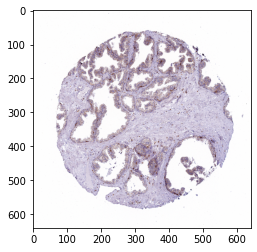

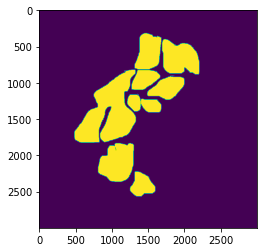

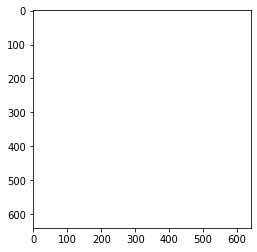

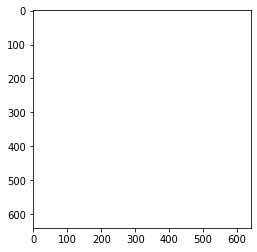

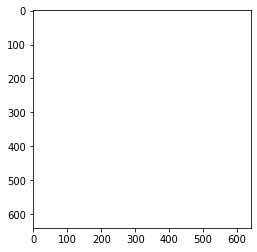

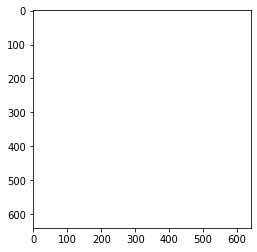

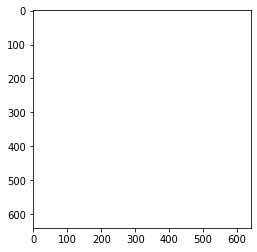

In [23]:
# CHECK PREDICTION
img = tiff.imread(df['path'][idx]).astype(np.float32)

shape = CFG['shape']

img = cv2.resize(img, shape)
# normalize
img = (img - img.min()) / (img.max() - img.min())
img = img.astype(np.float32)
plt.subplots(1)
plt.imshow(img)
mask = rle_decode(df['rle'][idx], df['img_width'][idx], df['img_height'][idx])
plt.subplots(1)
plt.imshow(mask)


img = img.reshape((1, 1, 3, shape[0], shape[1]))

prediction = trainer.predict(model, torch.tensor(img, ))
for a in prediction[0][0]:
    plt.subplots(1)
    plt.imshow(a)

(-0.5, 2999.5, 2999.5, -0.5)

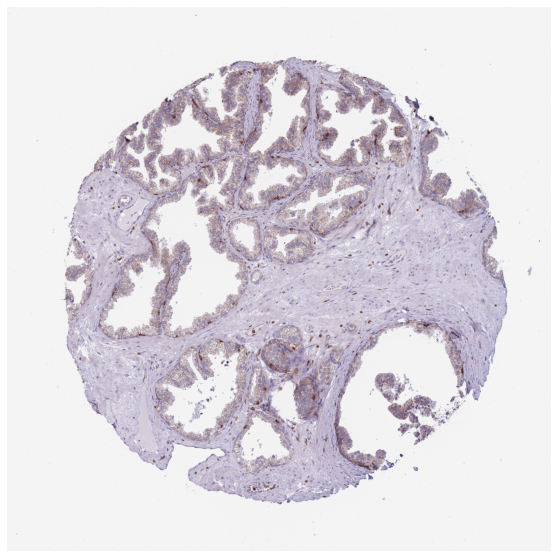

In [24]:
# CHECK ONE

idx = 0

img = tiff.imread(df['path'][idx])
mask = rle_decode(df['rle'][idx], df['img_width'][idx], df['img_height'][idx])

plt.figure(figsize=(10,10))
# plt.subplots(1)
# plt.imshow(img)
# plt.figure(figsize=(10,10))
# plt.subplots(1)
# plt.imshow(mask)
# plt.subplots(1)
plt.imshow(img)
# plt.imshow(mask, cmap='coolwarm', alpha=0.3)
# plt.imshow(color.label2rgb(mask, img, bg_label=0, bg_color=(1.,1.,1.), alpha=0.25))
plt.axis('off')